# Discovering and Learning the 1D Swift Hohenberg Equation

This file implements the Physics Informed Neural Networks (PINN) and Deep Hidden Phyics Models (DHPM) classes written by Maziar Raissi and modifies them to apply to the Swift-Hohenberg equation. Please refer to the following for more information:  
https://github.com/maziarraissi/PINNs
https://github.com/maziarraissi/DeepHPMs

## Set Up and Introduction 
The Swift-Hohenberg equation 
$$u_t = -(1+\Delta)^2 u - \mu u + \nu u^2 - u^3 $$
was derived in 1977 by Swift and Hohenberg to study thermal fluctuations of a fluid. We will be interested in the 1 dimensional Swift-Hohenberg equation, meaning $u = u(x,t)$ with $x,t \in \mathbb R$. 

This notebook is a companion to the notebook titled 'SolvingSH1D_Class.ipynb'. In this notebook, we will train a deep feed-forward neural network to predict the parameters $\mu$ and $\nu$ present in the PDE. Later we will train a different deep neural network to identify the PDE itself and then we will train another neural network to solve the PDE. 

It is important to note that this file uses version 1.14 of Tensorflow and Python 3.7 and will not be compatible with newer versions.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import scipy.io
import scipy.stats
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import numpy as np
import pandas as pd

In [2]:
tf.__version__

'1.14.0'

In [3]:
np.random.seed(1234)
tf.set_random_seed(1234)

import sys
sys.path.insert(0, '../../Utilities/')

import PhysicsInformedNN1 as NN
import DeepHiddenPhysicsModels1 as HPNN

Configure the file path here -- use cd and ls. 

## Data Preprocessing
First, we initialize the parameters and load the data. This data was generated via the matlab file titled 'sh_1d.m' and contains values for the solution $u(x,t)$ at $N = 512$ points in the spatial domain and $T = 201$ points in the temporal domain. The snapshots are $\Delta t = .025$ apart. 

In particular, we used a Fourier discretization with $250$ modes and a fourth order Runge-Kutta temporal integrator with time step size $10^{-4}$ within the Chebfun package.

In [4]:
# load the data
# data is a dictionary
data = scipy.io.loadmat("data/exp1d_HD.mat")

# set the parameter values
mu=1
nu=1.2

This is a multidimensional array containing $(x,t)$ values and solution values, $u(x,t)$ obtained using Chebfun in Matlab. 

The data vaThe spatial variable $x$ is under the key 'spatial_vec', the temporal variable $t$ is under the key 't_span' and the value of the solution $u(x,t)$ is under the key 'data'.

In [5]:
print('The keys are:', sorted(data.keys()))
print('The size of ''tspan'':', np.shape(data['tspan']))
print('The size of ''data'':', np.shape(data['data']))
print('The size of ''spatial_vec'':', np.shape(data['spatial_vec']))

The keys are: ['__globals__', '__header__', '__version__', 'data', 'spatial_vec', 'tspan']
The size of tspan: (1, 201)
The size of data: (512, 201)
The size of spatial_vec: (1, 512)


Now we work to format the initial data. 

In [6]:
## Extract the values for x and t
t = data['tspan'].flatten()[:,None]
x = data['spatial_vec'].flatten()[:,None]
# Extract the solution values
true_sol = np.real(data['data']).T

# Construct a coordinate grid for the domain data
X,T = np.meshgrid(x,t)

In [7]:
# Formats the domain data as a column vector with rows of the form (x,t)
domain_col = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_col = true_sol.flatten()[:,None]              

# Get domain bounds in the form (x,t)
lb = domain_col.min(0)
ub = domain_col.max(0) 

print('Lower bound (x,t): ', lb)
print('Upper bound (x,t): ', ub)

Lower bound (x,t):  [0. 0.]
Upper bound (x,t):  [20.  5.]


## Learning Parameters


In this section, we will work with unperturbed data only. The initial value problem we will be interested in as as follows: 

\begin{align*}u_t & = -u_{xxxx} - 2 u_{xx} +(-1+\mu)u + \nu u^2 - u^3, \qquad\qquad x \in [0,20], \quad t \in [0,5] \\
u(0,x) & = \exp \left\{-(x-10)^2  \right\} \\ 
\end{align*}

Define 
\begin{align*}
f(u) & = u_t + \mathcal N(u)\\
 & = u_t+u_{xxxx} + 2 u_{xx} -(-1+\mu)u - \nu u^2 + u^3
\end{align*}

The parameter $\mu$ can be thought of as measuring how far the temperature is above the minimum temperature required for convection. We will see if the neural network can predict the parameters for the Swift-Hohenberg equation. We will do this for unperturbed data and data with added noise sampled from a standard Gaussian distribution.
### Unperturbed Data
First we work with unperturbed data. Furthermore, we will train the model with data taken from the interior of the domain. As in the previous notebook (see 'SolvingSH1D-Class.ipynb'), we express the unknown solution $u(t,x)$ as a neural network and we define the function $f(u)$ via 
$$f(u) = u_t - \mathcal N(u;\mu, \nu).$$
Previously, the parameters $\mu, \nu$ were known. Now $\mu$ and $\nu$ are shared unknown parameters of $u_t$ and $\mathcal N(u;\mu,\nu)$. These parameters are determined by minimizing the squared error loss: 
\begin{align*} MSE & = MSE_f + MSU_u \\
& = \frac{1}{N} \sum_{i = 1}^N \bigg( \|\hat u(t_i, x_i) - u(t_i,x_i) \|^2 + \|f(t_i, x_i)\|^2 \bigg).
\end{align*}

#### Initialize Neural Network 
The training data is randomly sampled from the interior of the domain. We initially use $400$ training points. Additionally, we use $8$ hidden layers with $20$ nodes in each layer. 

In [8]:
# Set number of training points, collocation points and layers/neurons
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# Choose number of training data
Num=400
# Now our training data is not boundary data, but is taken from all over the spatial domain.
indices = np.random.choice(domain_col.shape[0], Num, replace=False)
X_u_train = domain_col[indices,:]
u_train = u_col[indices,:]

# initialize model
model = NN.PINN(X_u_train, u_train, None, layers, lb, ub,mu, nu, True)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Train and Predict

In [9]:
# Train the model and predict u, f
model.train(0, True)
u_pred, f_pred = model.predict(domain_col, True)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000152
  Number of iterations: 8009
  Number of functions evaluations: 8785


In [10]:
# get errors
error_u = np.linalg.norm(u_col-u_pred,2)
u_pred = griddata(domain_col, u_pred.flatten(), (X, T), method='cubic')

# get estimated parameter values and compute error
mu_value = model.sess.run(model.mu_find)
nu_value = model.sess.run(model.nu_find)
    
error_mu = np.abs(mu_value - mu)*100
error_nu = np.abs(nu_value - nu) * 100

# print
print('Error u: %e' % (error_u))   
print('Relative Error u: %e' % (error_u/np.linalg.norm(u_col,2)))    
print('Error mu: %.5f%%' % (error_mu))                             
print('Error nu: %.5f%%' % (error_nu))  
print('Estimated mu value: %.5f' %  mu_value)
print('Estimated nu value: %.5f' %  nu_value)

Error u: 3.259434e+00
Relative Error u: 1.269748e-02
Error mu: 1.33638%
Error nu: 0.74401%
Estimated mu value: 0.98664
Estimated nu value: 1.20744


We see that the model is able to determine $\mu$ and $\nu$ with reasonable accuracy. 

### Perturbed Data
Now we add noise to our data. This means our measurements $u$ now of the form 
$$ u_i = u(x_i,t_i) + \epsilon_i,$$
where $\epsilon_i \sim N(0,\sigma^2)$ and $u(x,t)$ is the true model.

More precisely, $\epsilon_i$ will always have zero mean, but $\sigma^2$ will be given by
$$ \sigma^2 = (n\sigma_u)^2,$$
where $n$ is a scalar noise level that can be altered and $\sigma^2_u$ is the variance of the distribution of the unperturbed measurements $u$.

#### Initialize the Neural Network
We choose an initial noise scaling $n = .02$. The model of the architecture remains the same as that in the previous section. We still use $400$ training points. 

In [11]:
# choose the noise factor
noise = 0.02        
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# initialize the model
model = NN.PINN(X_u_train, u_train, None, layers, lb, ub, mu, nu, True)

#### Train and Predict 
We perform $1000$ iterations to train the model. 

In [12]:
Niter = 1000
model.train(Niter, True)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000399
  Number of iterations: 7410
  Number of functions evaluations: 8176


In [13]:
# make predictions using the trained model 
u_pred, f_pred = model.predict(domain_col, True)

In [14]:
# get errors
error_u = np.linalg.norm(u_col-u_pred,2)
u_pred = griddata(domain_col, u_pred.flatten(), (X, T), method='cubic')

# get predicted mu and nu values
mu_value_noisy = model.sess.run(model.mu_find)
nu_value_noisy = model.sess.run(model.nu_find)
    
# compute errors
error_mu_noisy = np.abs(mu_value_noisy - mu)*100
error_nu_noisy = np.abs(nu_value_noisy - nu) * 100

# print the errors
print('Error of u: %e' % (error_u))  
print('Relative Error of u: %e' % (error_u/np.linalg.norm(u_col,2))) 
print()
print('Error of mu: %.5f%%' % (error_mu_noisy))                         
print('Error of nu: %.5f%%' % (error_nu_noisy))  
print()
print('Estimated mu value: %.5f' %  mu_value_noisy)
print('Estimated nu value: %.5f' %  nu_value_noisy)
print()
print('True mu value: %.5f' %  mu)
print('True nu value: %.5f' %  nu)

Error of u: 3.901137e+00
Relative Error of u: 1.519730e-02

Error of mu: 1.07740%
Error of nu: 0.56553%

Estimated mu value: 0.98923
Estimated nu value: 1.20566

True mu value: 1.00000
True nu value: 1.20000


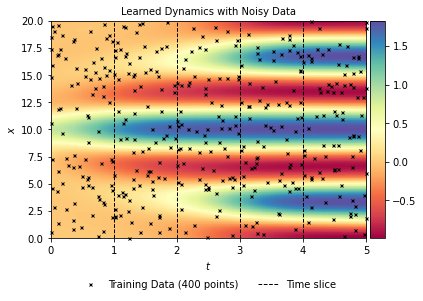

In [15]:
# plot as before
fig, ax = plt.subplots()

h = ax.imshow(u_pred.T, interpolation='nearest', cmap='Spectral', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Training Data (%d points)' % (u_train.shape[0]), markersize = 3, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'k--', linewidth = 1, label = 'Time slice')
ax.plot(t[80]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[120]*np.ones((2,1)), line, 'k--', linewidth = 1)    
ax.plot(t[160]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)
ax.set_title('Learned Dynamics with Noisy Data', fontsize = 10)

fig.savefig('pdfHD_rolls_1_pred_noise.pdf',  bbox_inches='tight')

fig.show()

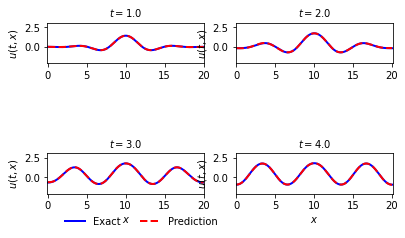

In [16]:
# plot as before

fig, ax = plt.subplots()

gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.1, right=0.9, hspace=0.5)

#fig.suptitle('True and Predicted Solution at Fixed Times with Perturbed Data')



ax = plt.subplot(gs1[0, 0])
ax.plot(x,true_sol[40,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred[40,:], 'r--', linewidth = 2, label = 'Prediction')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 1.0$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-0.1,20.1])
ax.set_ylim([-2.1,3.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,true_sol[80,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred[80,:], 'r--', linewidth = 2, label = 'Prediction')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-0.1,20.1])
ax.set_ylim([-2.1,3.1])
ax.set_title('$t = 2.0$', fontsize = 10)


ax = plt.subplot(gs1[1, 0])
ax.plot(x,true_sol[120,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred[120,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-0.1,20.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 3.0$', fontsize = 10)

ax = plt.subplot(gs1[1, 1])
ax.plot(x,true_sol[160,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred[160,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-0.1,20.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 4.0$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(-0.6, -0.35), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_pred_noise_slice.pdf',  bbox_inches='tight')

fig.show()

We see that the model is able to both identify the parameters $\mu$ and $\nu$ with high accuracy and predict the dynamics of the solution $u(x,t)$.

### Experimenting with Model Architecture
We now want to test the performance of the model on predicting the parameters $\mu$ and $\nu$ as we vary the number of layers, number of nodes in each layer, number of training data and the noise value. 

The following function initializes and trains models for pairwise combinations of the options for the model architecture. 

In [17]:
# write a function to compute a bunch of models for different values of noise, layers, neurons, and training points
def get_parameter_errors(num_train, noise, num_layers, num_neurons, data):
    
    # set true parameter values
    mu=1
    nu = 1.2
    
    # define the layers
    layers = np.concatenate([[2], num_neurons*np.ones(num_layers), [1]]).astype(int).tolist()    
    
    # get the time, space, and solution data and format it
    t = data['tspan'].flatten()[:,None]
    x = data['spatial_vec'].flatten()[:,None]
    sol = data['data'].T
    
    X, T = np.meshgrid(x,t)
    
    dom_col = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_col = sol.flatten()[:,None]              

    # get lower bound and upper bound for the domain
    lb = dom_col.min(0)
    ub = dom_col.max(0)    
    
    # sample the desired number of training points        
    indices = np.random.choice(dom_col.shape[0], num_train, replace=False)
    dom_train = dom_col[indices,:]
    u_train = u_col[indices,:]
    
    # add noise
    u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
   
    # initialize and train the model
    model = NN.PINN(dom_train, u_train, None, layers, lb, ub, mu, nu, True)
    model.train(1000, True)
    
    # predict u and f
    u_pred, f_pred = model.predict(dom_col, True)
    
    # get error
    error_u = np.linalg.norm(u_col-u_pred,2)
    
    # extract parameter values
    mu_val = model.sess.run(model.mu_find)
    nu_val = model.sess.run(model.nu_find)
    
    # get parameter errors
    
    error_mu = np.abs(mu_val - mu)*100
    error_nu = np.abs(nu_val - nu)*100
    
    print('Error of u: %e' % (error_u))
    print('Relative Error of u: %e' % (error_u/np.linalg.norm(u_col,2)))    
    print('Error mu: %.5f%%' % (error_mu))                             
    print('Error nu: %.5f%%' % (error_nu))
    print('Estimated mu: %.5f' % (mu_val))                             
    print('Estimated nu: %.5f' % (nu_val))
    
    
    return error_mu, error_nu

In the previous experiments, we had $8$ hidden layers with $20$ nodes, a noise factor of $0.02$ and $400$ training points. 

We choose the following values to experiment with: 
\begin{align*}
\text{# Training Points: } & 250, 750, 1500\\
\text{Noise Levels: } & 0.0, 0.05, 0.1\\
\text{# Layers: } & 2, 6, 8\\
\text{# Training Points: } & 250, 750, 1500\\
\end{align*}

In [18]:
#Set the desired number of training points, noise, layer, neurons
N = [250, 750, 1500]
noise = [0.0, 0.05, 0.1]

num_layers = [2,6,10]
num_neurons = [10,20,40]

In [19]:
# compute errors for the combinations and save to a table
mu_table_N_noise = np.zeros((len(N), len(noise)))
nu_table_N_noise = np.zeros((len(N), len(noise)))

for i in range(len(N)):
    for j in range(len(noise)):
        print('Number of Training Points: %f' % (N[i]))
        print('Noise Level: %f' % (noise[j]))
        mu_table_N_noise[i,j], nu_table_N_noise[i,j] = get_parameter_errors(N[i], noise[j], num_layers[-1], num_neurons[-1], data)
        

Number of Training Points: 250.000000
Noise Level: 0.000000
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000005
  Number of iterations: 7351
  Number of functions evaluations: 8037
Error of u: 2.197207e+00
Relative Error of u: 8.559456e-03
Error mu: 0.18765%
Error nu: 0.14431%
Estimated mu: 0.99812
Estimated nu: 1.20144
Number of Training Points: 250.000000
Noise Level: 0.050000
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000942
  Number of iterations: 6813
  Number of functions evaluations: 7453
Error of u: 9.844992e+00
Relative Error of u: 3.835223e-02
Error mu: 2.76623%
Error nu: 0.98640%
Estimated mu: 0.97234
Estimated nu: 1.20986
Number of Training Points: 250.000000
Noise Level: 0.100000
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective

In [23]:
np.savetxt('./tables/mu_table_N_noise.csv', mu_table_N_noise, delimiter=' & ', fmt='$%2.3f$', newline=' \\\\\n')
np.savetxt('./tables/nu_table_N_noise.csv', nu_table_N_noise, delimiter=' & ', fmt='$%2.3f$', newline=' \\\\\n')

rows = ['Num Training Points: ' + str(N[0])] + N[1:]
cols = ['Noise level: ' + str(noise[0])] + noise[1:]

mu_df_N_noise = pd.DataFrame(mu_table_N_noise, index = rows, columns = cols) 
nu_df_N_noise = pd.DataFrame(nu_table_N_noise, index = rows, columns = cols) 


In [25]:
# compute errors for the combinations and save to a table
mu_table_layers_neurons = np.zeros((len(num_layers), len(num_neurons)))
nu_table_layers_neurons = np.zeros((len(num_layers), len(num_neurons)))

for i in range(len(num_layers)): 
    for j in range(len(num_neurons)):
        print('Number of Layers: %f' % (num_layers[i]))
        print('Number of Neurons: %f' % (num_neurons[j]))
        mu_table_layers_neurons[i,j], nu_table_layers_neurons[i,j] = get_parameter_errors(500, noise[0], num_layers[i], num_neurons[j], data)

Number of Layers: 2.000000
Number of Neurons: 10.000000
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.001656
  Number of iterations: 4647
  Number of functions evaluations: 4964
Error of u: 7.303125e+00
Relative Error of u: 2.845011e-02
Error mu: 5.14641%
Error nu: 2.14437%
Estimated mu: 0.94854
Estimated nu: 1.22144
Number of Layers: 2.000000
Number of Neurons: 20.000000
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000234
  Number of iterations: 9319
  Number of functions evaluations: 10027
Error of u: 3.338379e+00
Relative Error of u: 1.300502e-02
Error mu: 0.89294%
Error nu: 0.27655%
Estimated mu: 0.99107
Estimated nu: 1.20277
Number of Layers: 2.000000
Number of Neurons: 40.000000
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function v

In [33]:
np.savetxt('./tables/mu_table_layers_neurons.csv', mu_table_layers_neurons, delimiter=' & ', fmt='$%2.3f$', newline=' \\\\\n')
np.savetxt('./tables/nu_table_layers_neurons.csv', nu_table_layers_neurons, delimiter=' & ', fmt='$%2.3f$', newline=' \\\\\n')

rows = ['Num Layers: ' + str(num_layers[0])] + num_layers[1:]
cols = ['Num Nodes: ' + str(num_neurons[0])] + num_neurons[1:]

mu_df_layers_neurons = pd.DataFrame(mu_table_layers_neurons, index = rows, columns = cols)
nu_df_layers_neurons = pd.DataFrame(nu_table_layers_neurons, index = rows, columns = cols)

In [ ]:
# compute errors for the combinations and save to a table
mu_table_noise_layers = np.zeros((len(noise), len(num_layers)))
nu_table_noise_layers = np.zeros((len(noise), len(num_layers)))

for i in range(len(noise)):
    for j in range(len(num_layers)):
        print('Noise Level: %f' % (noise[i]))
        print('Number of Layers: %f' % (num_layers[j]))
        mu_table_noise_layers[i,j], nu_table_noise_layers[i,j] = get_parameter_errors(500, noise[i], num_layers[j], 25, data)
    

In [31]:
np.savetxt('./tables/mu_table_noise_layers.csv', mu_table_noise_layers, delimiter=' & ', fmt='$%2.3f$', newline=' \\\\\n')
np.savetxt('./tables/nu_table_noise_layers.csv', nu_table_noise_layers, delimiter=' & ', fmt='$%2.3f$', newline=' \\\\\n')

rows = ['Noise level: ' + str(noise[0])] + noise[1:]
cols = ['Num Layers: ' + str(num_layers[0])] + num_layers[1:]

mu_df_noise_layers = pd.DataFrame(mu_table_noise_layers, index = rows, columns = cols)
nu_df_noise_layers = pd.DataFrame(nu_table_noise_layers, index = rows, columns = cols)

### Results 
Below we display the estimation errors of the parameters $\mu$ and $\nu$. 

1. When changing the number of training points and noise level, we fix the number of layers to be $10$ with $40$ neurons. 
2. When changing the number of layers and nodes in each layer, we set the number of training points to be $500$ and the noise level to be $0.0$. 
3. When changing the value of the noise level and the number of layers, we set the number of training points to be $500$ and we have $25$ nodes per layer. 

In [34]:
print('Percent Error for mu')
display(mu_df_N_noise)
display(mu_df_layers_neurons)
display(mu_df_noise_layers)
print()
print('Percent error for nu')
display(nu_df_layers_neurons)
display(nu_df_N_noise)
display(nu_df_noise_layers)

Percent Error for mu


,Noise level: 0.0,0.05,0.1
Num Training Points: 250,0.187653,2.766228,13.493454
750,0.103772,0.587744,4.815650
1500,0.040030,0.673962,2.070659


,Num Nodes: 10,20,40
Num Layers: 2,5.146408,0.892937,0.165707
6,0.288326,0.006557,0.318682
10,0.128484,0.254524,0.006640


,Num Layers: 2,6,10
Noise level: 0.0,0.284719,0.191849,0.054109
0.05,2.272820,1.972300,1.305640
0.1,3.816080,0.300938,2.669907



Percent error for nu


,Num Nodes: 10,20,40
Num Layers: 2,2.144372,0.276554,0.165308
6,0.200331,0.060499,0.106990
10,0.065768,0.139546,0.020826


,Noise level: 0.0,0.05,0.1
Num Training Points: 250,0.144315,0.986397,0.188518
750,0.090265,0.632954,4.219937
1500,0.046253,0.249064,1.737356


,Num Layers: 2,6,10
Noise level: 0.0,0.008118,0.038064,0.083804
0.05,1.371229,1.065397,0.411558
0.1,1.603878,0.991976,1.666462


## Learning the PDE and Extrapolating
The next learning algorithm works to learn the underlying dynamics of the pde; meaning if 
$ u_t = \mathcal N(u),$
this neural network learns $\mathcal N(u)$. This learned function $\mathcal N$ is a blackbox function, meaning we do not have a closed form expression for it. 

Then, the solution to the PDE $u_t = \mathcal N(u)$, where again $\mathcal N(u)$ is the learned function, is predicted via the PINNs algorithm in addition to the initial and boundary data. We can then compare this output to the true data. 

#### Data Preprocessing
We will use the same data as in the previous two sections. Later, we will use one set of data to identify the PDE and another to find the solution. For this reason, we make new variables for the set of data used to identify the PDE and the set of data used to find the solution (even though in this context they are the same data). 

In [35]:
# first load the data used to identify N
data_id=scipy.io.loadmat("data/exp1d_HD.mat")

# extract the data
t_id = data_id['tspan'].flatten()[:,None]
x_id = data_id['spatial_vec'].flatten()[:,None]
u_id = data_id['data']

# get lower and upper bounds
lb_id=np.array([min(t_id)[0], min(x_id)[0]])
ub_id=np.array([max(t_id)[0], max(x_id)[0]])

# Now we create a coordinate grid of (t,x)
T_id, X_id = np.meshgrid(t_id,x_id)

We want to extrapolate the last third of the data, so now we create arrays with just the first 2/3 of the temporal data and format them appropriately. 

In [36]:
# create and format data with the last third missing
keep=2/3

keep_index=int(keep*t_id.shape[0])
T_id=T_id[:,0:keep_index]
X_id=X_id[:,0:keep_index]
Sol_id=u_id[:,0:keep_index]

t_id_col=T_id.flatten()[:,None]
x_id_col=X_id.flatten()[:,None]
dom_id_col=np.hstack((t_id_col, x_id_col))
u_id_col=Sol_id.flatten()[:,None]

Now we load and format the data for solving the PDE. 

In [37]:
# extract the data used to find u from u_t = N
data_sol=scipy.io.loadmat("data/exp1d_HD.mat")
t_sol = data_sol['tspan'].flatten()[:,None]
x_sol = data_sol['spatial_vec'].flatten()[:,None]
u_sol = np.real(data_sol['data'])

# get lower and upper bounds
lb_sol=np.array([min(t_sol)[0], min(x_sol)[0]])
ub_sol=np.array([max(t_sol)[0], max(x_sol)[0]])

T_sol, X_sol = np.meshgrid(t_sol,x_sol)

# format the data
t_sol_col=T_sol.flatten()[:,None]
x_sol_col=X_sol.flatten()[:,None]
dom_sol_col=np.hstack((t_sol_col, x_sol_col))
u_sol_col=u_sol.flatten()[:,None]

Now we choose the number of training data to identify $\mathcal N$ and take a random number of these points from the identification data. 

In [38]:
# choose number of training points on which to identify N
N_train=10000
max_index=t_id_col.shape[0]
train_index=np.random.choice(max_index,N_train,replace=False)
t_train = t_id_col[train_index,:]
x_train = x_id_col[train_index,:]
u_train = u_id_col[train_index,:]

Now we make the data a little noisy (if we want). In this case, the results did not seem to be good enough without noise to justify adding noise.

In [39]:
noise = 0.00
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

#### Construct Training Data
Now we choose the training data to construct the solution $u(x,t)$. We will choose a number of points from the initial data at $t = 0$, a number of points containing other boundary data and a number of points from the interior of the domain that function as collocation points for the network $f$ and serve to enforce the structure of the learned PDE.

In [40]:
num_init = u_sol.shape[0]
num_bound = u_sol.shape[1]
num_f = 20000

# extract the training data
x_indices=np.random.choice(x_sol.shape[0], num_init, replace=False)
x0_train=x_sol[x_indices,:]
u0_train=u_sol[x_indices,0:1]

t_indices=np.random.choice(t_sol.shape[0],num_bound, replace=False)
tb_train=t_sol[t_indices,:]

X_f_train=lb_sol+(ub_sol-lb_sol)*lhs(2,N_train)

#### Initialize Model
Now we decide how many layers we want and initialize our model. In this case, we choose $4$ hidden layers with $50$ nodes in each layer for the solution $u(x,t)$, the PDE $\mathcal N$ and the solver. 

In [61]:
# first u layer should be the number of inputs (x,t)
u_layers = [2, 20, 20, 20, 20, 20, 20, 20, 20,  1]
# first pde layer should be the number of derivatives needed (max spatial order + max temporal order). We choose 5 because we know
# our data was generated from SH; a fourth order PDE
pde_layers = [5, 20, 20, 20, 20, 20, 20, 20,20, 1]
# for solving -- first layer should be number of inputs, last layer is number of outputs
layers = [2, 20, 20, 20, 20, 20, 20, 20,20,   1]
    
# Inialize the model
model = HPNN.DeepHPM(t_train, x_train, u_train,
                x0_train, u0_train, tb_train, X_f_train,
                u_layers, pde_layers,
                layers,
                lb_id, ub_id,
                lb_sol, ub_sol)

#### Train and Predict
Now we train the identifier and obtain its prediction on the training data. 

In [62]:
# train the models to get u_t = N
model.idn_u_train(N_iter=0)
model.idn_f_train(N_iter=0)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.012342
  Number of iterations: 18271
  Number of functions evaluations: 19466
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 0.023237
  Number of iterations: 46260
  Number of functions evaluations: 50002


Now we train the solver. 

In [63]:
# train the model to get u from u_t = N
model.sol_train(N_iter=0)

# pred_sol1 correspond to the predictions of u on the training data used to train the solver
# pred_sol2 correspond to the predictions of u on the training data used to identify; i.e. find N(u)

u_pred_sol1, f_pred_sol1 = model.sol_predict(t_sol_col, x_sol_col)
u_pred_sol2, f_pred_sol2 = model.sol_predict(t_id_col, x_id_col)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 68.005455
  Number of iterations: 226
  Number of functions evaluations: 274


In [64]:
# print errors
error_u = np.linalg.norm(u_sol_col-u_pred_sol1,2)
error_u_id = np.linalg.norm(u_id_col-u_pred_sol2,2)/np.linalg.norm(u_id_col,2)
print('Relative Error u: %e' % (error_u/np.linalg.norm(u_sol_col,2)))
print('Error u: %e' % (error_u))
print('Error u (idn): %e' % (error_u_id))

U_pred = griddata(dom_sol_col, u_pred_sol1.flatten(), (T_sol, X_sol), method='cubic')

Relative Error u: 1.125930e+00
Error u: 1.955756e+02
Error u (idn): 1.101778e+00


Now we can plot the results. 

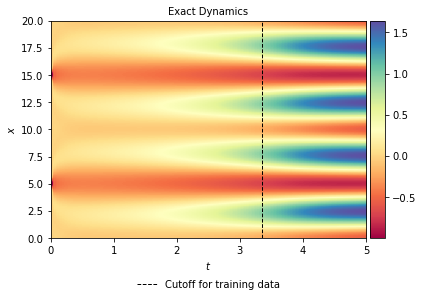

In [65]:
# We plot the true dynamics

fig, ax = plt.subplots()

h = ax.imshow(u_sol, interpolation='nearest', cmap='Spectral', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

line = np.linspace(lb_sol[1], ub_sol[1], 2)[:,None]
ax.plot(t_id[keep_index]*np.ones((2,1)), line, 'k--', linewidth = 1, label="Cutoff for training data")

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Exact Dynamics', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_1_discover_exact.pdf', bbox_inches='tight')
fig.show()

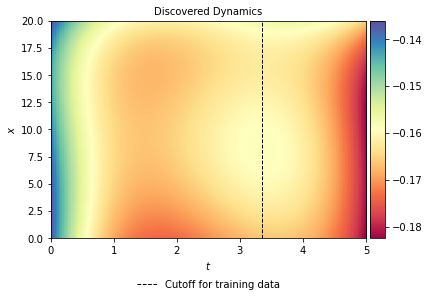

In [66]:
# We plot the dynamics that were learned using PINN from the function N generated by HPM 
fig,ax = plt.subplots()
h = ax.imshow(U_pred, interpolation='nearest', cmap='Spectral', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

line = np.linspace(lb_sol[1], ub_sol[1], 2)[:,None]
ax.plot(t_id[keep_index]*np.ones((2,1)), line, 'k--', linewidth = 1, label="Cutoff for training data")

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Discovered Dynamics', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)


fig.savefig('pdfHD_rolls_1_1_discover_pred.pdf', bbox_inches='tight')
fig.show()

### Learning Dynamics on a Different Data Set
Now we see if the neural network can model a solution with a different initial condition. Previously, we were using the same data set to train the model to identify and solve the PDE. Now we use one solution to train the model to identify the PDE and another data set to train the model to solve the PDE. 

#### Data Preprocessing
We load the data for a different solution to the Swift-Hohenberg Equation. See Section 4.2 of the accompanying technical report for plots of these solutions. 

In [67]:
# load the other data for SH
data_sol=scipy.io.loadmat("data/exp1d_HD_even.mat")

In [68]:
# Format the data
t_sol = data_sol['tspan'].flatten()[:,None]
x_sol = data_sol['spatial_vec'].flatten()[:,None]
u_sol = np.real(data_sol['data'])

lb_sol=np.array([min(t_sol)[0], min(x_sol)[0]])
ub_sol=np.array([max(t_sol)[0], max(x_sol)[0]])

T_sol, X_sol = np.meshgrid(t_sol,x_sol)

# flatten the data to vector form
t_sol_col=T_sol.flatten()[:,None]
x_sol_col=X_sol.flatten()[:,None]
dom_sol_col=np.hstack((t_sol_col, x_sol_col))
u_sol_col=u_sol.flatten()[:,None]

Here we have the option to add noise to the data. Similar to the previous experiment, the results from noiseless training data where not compelling enough to do so. 

In [69]:
# set the noise level and perturb the training data
noise = 0.00
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

Now we choose the training data to construct the solution $u(x,t)$. We will choose a number of points from the initial data at $t = 0$, a number of points containing other boundary data and a number of points from the interior of the domain that function as collocation points for the network $f$ and serve to enforce the structure of the learned PDE.

In [70]:
# choose the 
N0 = u_sol.shape[0]
N_b = u_sol.shape[1]
N_f = 2000

In [71]:
x_indices=np.random.choice(x_sol.shape[0], N0, replace=False)
x0_train=x_sol[x_indices,:]
u0_train=u_sol[x_indices,0:1]

In [72]:
t_indices=np.random.choice(t_sol.shape[0],N_b, replace=False)
tb_train=t_sol[t_indices,:]

In [73]:
X_f_train=lb_sol+(ub_sol-lb_sol)*lhs(2,N_f)

#### Initialize the model 
Now we decide how many layers we want and initialize our model. We must choose network architecture for $3$ neural networks; the solution $u(x,t)$, the PDE $\mathcal N$ and the solver. 

In [74]:
# first u layer should be the number of inputs (x,t)
u_layers = [2, 30, 30, 30, 30, 30, 1]
# first pde layer should be the number of derivatives needed (max spatial order + max temporal order)
pde_layers = [5, 40, 40, 40, 40, 40, 1]
# for solving -- first layer should be number of inputs, last layer is number of outputs
layers = [2, 30, 30, 30, 30, 30, 30, 1]
    
# Model -- we want to use t_train, x_train, etc from the previous data set to see if the network can extrapolate
model = HPNN.DeepHPM(t_train, x_train, u_train,
                x0_train, u0_train, tb_train, X_f_train,
                u_layers, pde_layers,
                layers,
                lb_id, ub_id,
                lb_sol, ub_sol)

#### Train and Predict
First we train the identifier.

In [75]:
model.idn_u_train(N_iter=0)
model.idn_f_train(N_iter=0)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.011507
  Number of iterations: 14978
  Number of functions evaluations: 15796
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 0.057742
  Number of iterations: 46387
  Number of functions evaluations: 50001


Next, we train the solver. 

In [76]:
model.sol_train(N_iter=0)
u_pred, f_pred = model.sol_predict(t_sol_col, x_sol_col)
u_pred_id, f_pred_id = model.sol_predict(t_id_col, x_id_col)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 27.219980
  Number of iterations: 1459
  Number of functions evaluations: 1853


In [77]:
# print errors
error_u = np.linalg.norm(u_sol_col-u_pred,2)
error_u_id = np.linalg.norm(u_id_col-u_pred_id,2)/np.linalg.norm(u_id_col,2)

print('Relative Error of u: %e' % (error_u/np.linalg.norm(u_sol_col,2)))
print('Error of u: %e' % (error_u))
print('Erro of u (identification): %e' % (error_u_id))

U_pred = griddata(dom_sol_col, u_pred.flatten(), (T_sol, X_sol), method='cubic')

Relative Error of u: 1.011189e+00
Error of u: 1.756449e+02
Erro of u (identification): 1.009590e+00


Now we plot the true and predicted dynamics. With the choice of initial conditions, we expect to see uniform stripes. 

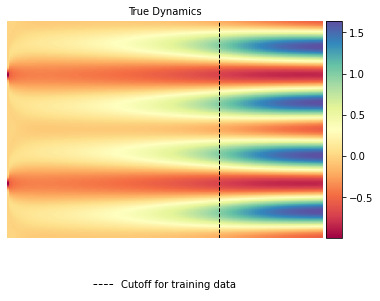

In [78]:
# plot as before
fig, ax = plt.subplots()
ax.axis('off')

h = ax.imshow(u_sol, interpolation='nearest', cmap='Spectral', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
line = np.linspace(lb_sol[1], ub_sol[1], 2)[:,None]

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('True Dynamics', fontsize = 10)
ax.plot(t_id[keep_index]*np.ones((2,1)), line, 'k--', linewidth = 1, label="Cutoff for training data")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_2_true.pdf', bbox_inches='tight')
fig.show()

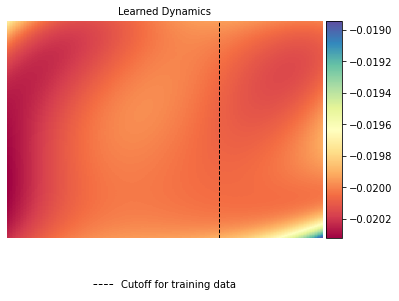

In [79]:
# plot as before
fig, ax = plt.subplots()
ax.axis('off')
h = ax.imshow(U_pred, interpolation='nearest', cmap='Spectral', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
line = np.linspace(lb_sol[1], ub_sol[1], 2)[:,None]

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Learned Dynamics', fontsize = 10)
ax.plot(t_id[keep_index]*np.ones((2,1)), line, 'k--', linewidth = 1, label="Cutoff for training data")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_2_discover.pdf', bbox_inches='tight')
fig.show()